In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install cython

In [4]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3budksr2
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3budksr2
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263902 sha256=2cbdd0be638f7e3965a406b3520f7fd35c8075157376bbe2e569523597c5daba
  Stored in directory: /tmp/pip-ephem-wheel-cache-e54pew3m/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [5]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2021-06-27 05:42:35--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  24.4MB/s    in 2.1s    

2021-06-27 05:42:37 (24.4 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [6]:
!unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [7]:
import os
import numpy as np
import torch
import torch.utils.data

In [8]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
from PIL import Image, ImageDraw #Image Draw란?
import matplotlib.pyplot as plt

dataset = PennFudanDataset('PennFudanPed/')
tmp_img = dataset[0][0]
draw = ImageDraw.Draw(tmp_img)
bbs = dataset[0][1]["boxes"]
for bb in bbs:
  draw.rectangle(bb.cpu().numpy(), outline=(255, 0, 0), width=3)

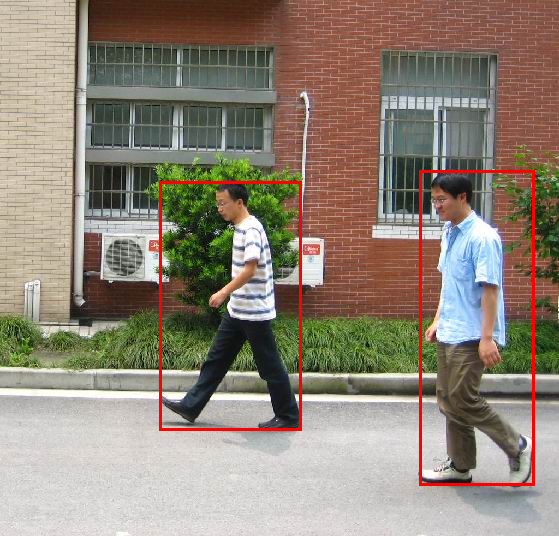

In [10]:
tmp_img

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [12]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29870, done.
remote: Counting objects: 100% (2412/2412), done.
remote: Compressing objects: 100% (637/637), done.
remote: Total 29870 (delta 1823), reused 2277 (delta 1730), pack-reused 27458
Receiving objects: 100% (29870/29870), 37.80 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (22438/22438), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [16]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
  transforms = []
  #converts the image, a PIL image, into a Pytorch tensor
  transforms.append(T.ToTensor())
  if train:
    #during training, randomly flip the training images
    #and ground-truth for data augmentation
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [18]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle=True, num_workers =4,
    collate_fn = utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset, batch_size = 1, shuffle=False, num_workers =4,
    collate_fn = utils.collate_fn
)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
!nvidia-smi

Sun Jun 27 05:49:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
#여기 데이터셋에는 2개의 class 뿐이다. 배경-사람
num_classes = 2

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum = 0.9, weight_decay=0.00005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [23]:
num_epochs = 50

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:29  lr: 0.000090  loss: 0.4546 (0.4546)  loss_classifier: 0.2111 (0.2111)  loss_box_reg: 0.2339 (0.2339)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 0.4836  data: 0.1833  max mem: 3692
Epoch: [0]  [10/60]  eta: 0:00:17  lr: 0.000936  loss: 0.4678 (0.5268)  loss_classifier: 0.2111 (0.2120)  loss_box_reg: 0.2904 (0.3021)  loss_objectness: 0.0057 (0.0082)  loss_rpn_box_reg: 0.0041 (0.0044)  time: 0.3593  data: 0.0225  max mem: 5021
Epoch: [0]  [20/60]  eta: 0:00:13  lr: 0.001783  loss: 0.4145 (0.4568)  loss_classifier: 0.1189 (0.1537)  loss_box_reg: 0.2842 (0.2888)  loss_objectness: 0.0072 (0.0095)  loss_rpn_box_reg: 0.0035 (0.0047)  time: 0.3322  data: 0.0066  max mem: 5021
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.002629  loss: 0.3016 (0.3918)  loss_classifier: 0.0721 (0.1254)  loss_box_reg: 0.2140 (0.2536)  loss_objectness: 0.0062 (0.0082)  loss_rpn_box_reg: 0.0034 (0.0046)  time: 0.3141  data: 0.0064  max mem: 5021
Epoch: [

In [24]:
img, _  = dataset_test[10]
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

In [25]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

img_new = Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())
draw = ImageDraw.Draw(img_new)

bbs = prediction[0]['boxes']

for bb in bbs:
  draw.rectangle(bb.cpu().numpy(), outline=(0, 255, 255),width = 3)

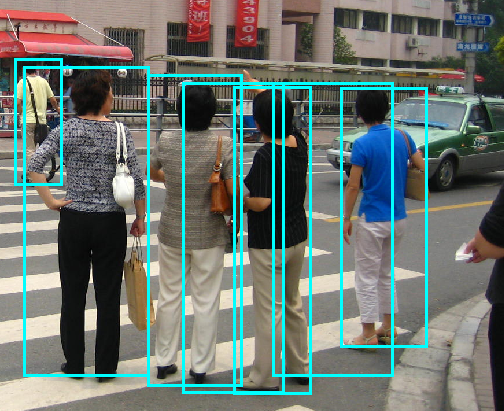

In [26]:
img_new

50번 돌린거나 10번 돌린거나 결과가 어째 비슷한 것 같다...